In [1]:
import pandas as pd
import numpy as np
import folium
from shapely.geometry import Point, LineString
from shapely.affinity import scale
from shapely.geometry import mapping
from folium.plugins import HeatMap
from shapely.geometry import LineString
from scipy.spatial import cKDTree

In [2]:
# 1. 데이터 로드
df_all = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\jeju_with_coords_kakao.csv").dropna(
    subset=['출발_lat', '출발_lon', '도착_lat', '도착_lon'])


In [3]:
# 2. 타원형 회피 경계 정의
center = Point(126.55, 33.368)  # 중심 약간 아래로 이동한 위치
circle = center.buffer(0.0825, resolution=80)  # 반지름 약 9.15km
ellipse = scale(circle, xfact=2.0, yfact=0.75, origin=center)  # 타원 비율 조정

In [4]:
# 3. 교차 판단 함수

def count_intersections(line, polygon):
    inter = line.intersection(polygon)
    if inter.is_empty:
        return 0
    if inter.geom_type == 'Point':
        return 1
    if inter.geom_type == 'MultiPoint':
        return len(inter.geoms)
    if inter.geom_type == 'LineString':
        return 2
    if inter.geom_type == 'MultiLineString':
        return sum(1 for g in inter.geoms if g.length > 0)
    return 3

In [5]:
# 4. 회피점 탐색 함수


def find_valid_random_midpoint(start, end, barrier, max_attempts=20, initial_buffer=0.005, step=0.003, samples=100):
    for i in range(max_attempts):
        dist = initial_buffer + i * step
        buffer_ring = barrier.buffer(dist).exterior
        candidate_pts = list(buffer_ring.coords)[
            ::max(1, len(buffer_ring.coords)//samples)]
        for pt in candidate_pts:
            mid = Point(pt)
            l1, l2 = LineString([start, mid]), LineString([mid, end])
            if count_intersections(l1, barrier) <= 1 and count_intersections(l2, barrier) <= 1:
                return mid, dist
    return None, None

In [6]:
# 5. 전체 경로 처리
records = []
for _, row in df_all.iterrows():
    sp = Point(row['출발_lon'], row['출발_lat'])
    ep = Point(row['도착_lon'], row['도착_lat'])
    direct = LineString([sp, ep])

    if not direct.intersects(ellipse):
        records.append({
            '출발_lat': sp.y, '출발_lon': sp.x,
            '도착_lat': ep.y, '도착_lon': ep.x,
            '우회_lat': None, '우회_lon': None,
            '우회_성공': False, '비고': '경계 외'
        })
        continue

    mid, dist = find_valid_random_midpoint(sp, ep, ellipse)
    if mid:
        records.append({
            '출발_lat': sp.y, '출발_lon': sp.x,
            '도착_lat': ep.y, '도착_lon': ep.x,
            '우회_lat': mid.y, '우회_lon': mid.x,
            '우회_성공': True,
            '비고': f'Buffer={dist:.5f}'
        })
    else:
        records.append({
            '출발_lat': sp.y, '출발_lon': sp.x,
            '도착_lat': ep.y, '도착_lon': ep.x,
            '우회_lat': None, '우회_lon': None,
            '우회_성공': False,
            '비고': '우회 실패'
        })

In [8]:
# CSV로 저장
pd.DataFrame(records).to_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\_5_17\\ju_paths_with_reroute_combined.csv", index=False)
print("✅ 전체 경로 우회 포함 CSV 저장 완료 → ju_paths_with_reroute_combined.csv")

✅ 전체 경로 우회 포함 CSV 저장 완료 → ju_paths_with_reroute_combined.csv


In [8]:
# 7. 지도 시각화
m = folium.Map(location=[33.38, 126.55], zoom_start=11)

In [ ]:
# 경로 표시 (모두 파란색)
for _, row in reroute_df.iterrows():
    sp = [row['출발_lat'], row['출발_lon']]
    ep = [row['도착_lat'], row['도착_lon']]

    if row['우회_성공']:
        mid = [row['우회_lat'], row['우회_lon']]
        folium.PolyLine([sp, mid, ep], color="blue",
                        weight=2.5, opacity=0.9).add_to(m)
    else:
        folium.PolyLine([sp, ep], color="blue", weight=2.5,
                        opacity=0.6).add_to(m)

NameError: name 'reroute_df' is not defined

In [12]:
# 중간 결과물 표시
m.save("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\_5_17\\rerouted_paths_all_blue.html")
print("🗺️ 지도 저장 완료: rerouted_paths_all_blue.html")

🗺️ 지도 저장 완료: rerouted_paths_all_blue.html


## 충전소 와 병합

In [13]:
# 충전소 파일 로드
charger_df = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv").dropna(
    subset=["lat", "lon"])

In [14]:
#  충전소 시각화 (빨간색 점)
for _, row in charger_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

In [15]:
m.save("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\_5_17\\rerouted_paths_with_chargers.html")
print("✅ HTML 파일 저장 완료: rerouted_paths_with_chargers.html")

✅ HTML 파일 저장 완료: rerouted_paths_with_chargers.html


In [16]:
# 경로 + 우회 여부 포함된 CSV (전체 경로)
df = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\_5_17\\rerouted_elliptical_paths_all.csv")

# 충전소 위치 CSV
chargers = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv").dropna(subset=["lat", "lon"])

In [17]:
# 2. 경로 점 생성
route_points = []

for _, row in df.iterrows():
    try:
        start = (float(row['출발_lon']), float(row['출발_lat']))
        end = (float(row['도착_lon']), float(row['도착_lat']))

        if row['우회_성공'] and pd.notna(row['우회_lat']) and pd.notna(row['우회_lon']):
            mid = (float(row['우회_lon']), float(row['우회_lat']))
            segments = [LineString([start, mid]), LineString([mid, end])]
        else:
            segments = [LineString([start, end])]

        for segment in segments:
            length = segment.length
            num_points = int(length / 0.003)  # 약 300m 간격
            # num_points = int(length / 0.003)  # 약 500m 간격
            for i in range(num_points + 1):
                point = segment.interpolate(
                    i / max(1, num_points), normalized=True)
                route_points.append([point.y, point.x])
    except Exception as e:
        continue  # 오류 발생 시 해당 행 건너뜀

In [18]:
# 3. 좌표 정제
route_points = [
    [float(lat), float(lon)]
    for lat, lon in route_points
    if pd.notna(lat) and pd.notna(lon)
]

charger_coords = [
    [float(row['lat']), float(row['lon'])]
    for _, row in chargers.iterrows()
    if pd.notna(row['lat']) and pd.notna(row['lon'])
]

In [ ]:
# # 4. KDTree 생성
# charger_tree = cKDTree(charger_coords)

# # 5. 각 경로에 대해 가장 가까운 충전소 찾기


# def find_nearest_charger(route_point):
#     dist, index = charger_tree.query(route_point)
#     return charger_coords[index], dist

ValueError: could not convert string to float: ''

In [57]:
# 4. 지도 생성 및 히트맵 추가
m = folium.Map(location=[33.38, 126.55], zoom_start=11)

HeatMap(route_points, radius=10, blur=5, min_opacity=0.3,
        gradient={0.2: 'lightblue', 0.5: 'blue', 0.8: 'navy'}).add_to(m)

HeatMap(charger_coords, radius=12, blur=6, min_opacity=0.4,
        gradient={0.2: 'pink', 0.5: 'red', 0.9: 'darkred'}).add_to(m)

In [32]:
# 5. 저장
m.save("heatmap_routes_and_chargers.html")
print("✅ 히트맵 저장 완료: heatmap_routes_and_chargers.html")

✅ 히트맵 저장 완료: heatmap_routes_and_chargers.html


In [ ]:

# 1. 데이터 로드
df = pd.read_csv(
    "C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\rerouted_elliptical_paths_all.csv")
chargers = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv").dropna(
    subset=["lat", "lon"])

# 2. 경로 좌표 추출
route_points = []
for _, row in df.iterrows():
    try:
        sp = (float(row['출발_lon']), float(row['출발_lat']))
        ep = (float(row['도착_lon']), float(row['도착_lat']))

        if row['우회_성공'] and pd.notna(row['우회_lat']) and pd.notna(row['우회_lon']):
            mp = (float(row['우회_lon']), float(row['우회_lat']))
            segments = [LineString([sp, mp]), LineString([mp, ep])]
        else:
            segments = [LineString([sp, ep])]

        for seg in segments:
            n = int(seg.length / 0.005)
            for i in range(n + 1):
                p = seg.interpolate(i / max(n, 1), normalized=True)
                route_points.append([p.y, p.x])
    except:
        continue

# 3. 좌표 정제


def clean_coordinates(coords):
    clean = []
    for pt in coords:
        if (
            isinstance(pt, (list, tuple)) and
            len(pt) == 2 and
            all(isinstance(x, (int, float)) and not pd.isna(x) for x in pt)
        ):
            clean.append([float(pt[0]), float(pt[1])])
    return clean


route_points = clean_coordinates(route_points)
charger_coords = clean_coordinates(chargers[['lat', 'lon']].values.tolist())

# 4. 시각화
m = folium.Map(location=[33.38, 126.55], zoom_start=11)
HeatMap(route_points, radius=10).add_to(m)
HeatMap(charger_coords, radius=12).add_to(m)
m.save("발표자료/heatmap_routes_and_chargers.html")
print(f"✅ 저장 완료: heatmap_routes_and_chargers.html")

✅ 저장 완료: heatmap_routes_and_chargers.html


C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 52649 (\N{HANGUL SYLLABLE CUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\charl\AppData\Local\Temp\ipykernel_36008\3971513638.py:90: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing 

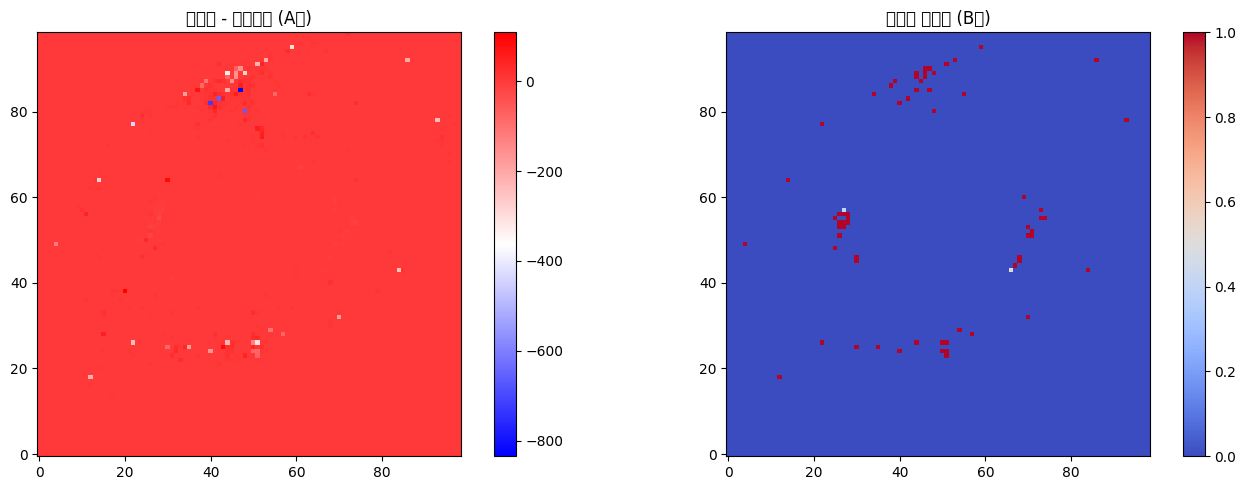

In [83]:

# 1. 데이터 로드
path_df = pd.read_csv(
    "C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\rerouted_elliptical_paths_all.csv").fillna("")
charger_df = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv").fillna("").dropna(
    subset=["lat", "lon"])

# 2. 경로 점 추출 (출발, 도착, 우회 포함)
def safe_float(val):
    try:
        return float(val)
    except (ValueError, TypeError):
        return None

route_points = []
for _, row in path_df.iterrows():
    lat, lon = safe_float(row['출발_lat']), safe_float(row['출발_lon'])
    if lat is not None and lon is not None:
        route_points.append([lat, lon])
    lat, lon = safe_float(row['우회_lat']), safe_float(row['우회_lon'])
    if lat is not None and lon is not None:
        route_points.append([lat, lon])
    lat, lon = safe_float(row['도착_lat']), safe_float(row['도착_lon'])
    if lat is not None and lon is not None:
        route_points.append([lat, lon])

route_points = np.array(route_points, dtype=float)

# 충전소 좌표도 float으로 변환
charger_coords = []
for _, row in charger_df.iterrows():
    lat, lon = safe_float(row['lat']), safe_float(row['lon'])
    if lat is not None and lon is not None:
        charger_coords.append([lat, lon])
charger_coords = np.array(charger_coords, dtype=float)

# 3. 격자 설정
lat_min, lat_max = 33.15, 33.55
lon_min, lon_max = 126.15, 126.95
grid_size = 100
lat_bins = np.linspace(lat_min, lat_max, grid_size)
lon_bins = np.linspace(lon_min, lon_max, grid_size)


def filter_valid_heatmap_data(data):
    valid = []
    for pt in data:
        if isinstance(pt, (list, tuple)) and len(pt) in [2, 3]:
            if all(isinstance(x, (int, float)) and np.isfinite(x) for x in pt):
                valid.append(pt)
    return valid

HeatMap(filter_valid_heatmap_data(route_points.tolist()), ...)
HeatMap(filter_valid_heatmap_data(charger_coords.tolist()), ...)
HeatMap(filter_valid_heatmap_data(a_heat), ...)
HeatMap(filter_valid_heatmap_data(b_heat), ...)


# 4. A안: 격자 기반 히트맵 차이
route_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])
charger_hist, _, _ = np.histogram2d(
    charger_coords[:, 0], charger_coords[:, 1], bins=[lat_bins, lon_bins])
adequacy_grid_a = charger_hist - route_hist  # +면 과잉, -면 부족

# 5. B안: KDTree로 경로 커버율 계산
tree = cKDTree(charger_coords)
distances, _ = tree.query(route_points, distance_upper_bound=0.009)  # 약 1km
is_covered = distances != np.inf
covered_points = route_points[is_covered]

covered_hist, _, _ = np.histogram2d(
    covered_points[:, 0], covered_points[:, 1], bins=[lat_bins, lon_bins])
total_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])
with np.errstate(divide='ignore', invalid='ignore'):
    coverage_ratio = np.nan_to_num(covered_hist / total_hist)

# 6. 결과 시각화 예시
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("충전소 - 이동경로 (A안)")
plt.imshow(adequacy_grid_a, cmap='bwr', origin='lower')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("충전소 커버율 (B안)")
plt.imshow(coverage_ratio, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar()

plt.tight_layout()
plt.show()

In [36]:
print(df.dtypes)
print(chargers.dtypes)

출발행정코드    float64
도착행정코드    float64
출발 주소      object
도착 주소      object
출발_lat    float64
출발_lon    float64
도착_lat    float64
도착_lon    float64
우회_lat    float64
우회_lon    float64
사용버퍼      float64
dtype: object
충전소명      object
주소        object
상세주소      object
충전기ID      int64
충전방식      object
충전상태      object
설치년도       int64
lat      float64
lon      float64
dtype: object


In [84]:
# # 2. 이동경로 포인트 추출
# route_points = []
# for _, row in path_df.iterrows():
#     if pd.notna(row['출발_lat']) and pd.notna(row['출발_lon']):
#         route_points.append([row['출발_lat'], row['출발_lon']])
#     if pd.notna(row['우회_lat']) and pd.notna(row['우회_lon']):
#         route_points.append([row['우회_lat'], row['우회_lon']])
#     if pd.notna(row['도착_lat']) and pd.notna(row['도착_lon']):
#         route_points.append([row['도착_lat'], row['도착_lon']])
# route_points = np.array(route_points)
# charger_coords = charger_df[['lat', 'lon']].values

# 2. 경로 포인트 추출 (NaN 포함 방지)
route_points = []
for _, row in df.iterrows():
    for lat, lon in [
        (row.get('출발_lat'), row.get('출발_lon')),
        (row.get('우회_lat'), row.get('우회_lon')),
        (row.get('도착_lat'), row.get('도착_lon')),
    ]:
        # 빈 문자열, None, NaN 등은 건너뜀
        if lat is None or lon is None or str(lat).strip() == "" or str(lon).strip() == "":
            continue
        try:
            lat = float(lat)
            lon = float(lon)
            if np.isfinite(lat) and np.isfinite(lon):
                route_points.append([lat, lon])
        except Exception:
            continue
route_points = np.array(route_points, dtype=float)

charger_coords = charger_df[['lat', 'lon']].dropna().astype(float).values

ValueError: could not convert string to float: ''

In [22]:
# 3. 격자 정의
lat_min, lat_max = 33.15, 33.55
lon_min, lon_max = 126.15, 126.95
grid_size = 100
lat_bins = np.linspace(lat_min, lat_max, grid_size)
lon_bins = np.linspace(lon_min, lon_max, grid_size)

In [30]:
# 4. 히트맵 계산
route_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])
charger_hist, _, _ = np.histogram2d(
    charger_coords[:, 0], charger_coords[:, 1], bins=[lat_bins, lon_bins])
adequacy = charger_hist - route_hist

tree = cKDTree(charger_coords)
distances, _ = tree.query(route_points, distance_upper_bound=0.009)
is_covered = distances != np.inf
covered_points = route_points[is_covered]

covered_hist, _, _ = np.histogram2d(
    covered_points[:, 0], covered_points[:, 1], bins=[lat_bins, lon_bins])
total_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])
with np.errstate(divide='ignore', invalid='ignore'):
    coverage_ratio = np.nan_to_num(covered_hist / total_hist)



In [85]:
# 5. 유효성 검사 함수


def is_valid_triplet(x):
    return (
        isinstance(x, (list, tuple)) and len(x) == 3 and
        all(isinstance(i, (int, float)) and np.isfinite(i) for i in x)
    )


def filter_valid_heatmap_data(data):
    valid = []
    for pt in data:
        if isinstance(pt, (list, tuple)) and len(pt) in [2, 3]:
            if all(isinstance(x, (int, float)) and np.isfinite(x) for x in pt):
                valid.append(pt)
    return valid


HeatMap(filter_valid_heatmap_data(route_points.tolist()), ...)
HeatMap(filter_valid_heatmap_data(charger_coords.tolist()), ...)
HeatMap(filter_valid_heatmap_data(a_heat), ...)
HeatMap(filter_valid_heatmap_data(b_heat), ...)

# 6. 지도 생성
m = folium.Map(location=[33.38, 126.55], zoom_start=11)

# 🟦 이동경로 수요
HeatMap(route_points.tolist(),
        name="🟦 이동경로 수요",
        radius=10, blur=5, min_opacity=0.3,
        gradient={0.2: 'lightblue', 0.5: 'blue', 0.8: 'navy'}
        ).add_to(m)

# 🟥 충전소 공급
HeatMap(charger_coords.tolist(),
        name="🟥 충전소 공급",
        radius=12, blur=6, min_opacity=0.4,
        gradient={0.2: 'pink', 0.5: 'red', 0.9: 'darkred'}
        ).add_to(m)


def is_valid_triplet(x):
    return (
        isinstance(x, (list, tuple)) and len(x) == 3 and
        all(isinstance(i, (int, float)) and np.isfinite(i) for i in x)
    )

In [94]:
# 🔁 A안: 적정성 히트맵
a_heat = []
for i in range(adequacy.shape[0]):
    for j in range(adequacy.shape[1]):
        val = adequacy[i, j]
        if not np.isfinite(val):
            continue
        lat = (lat_bins[i] + lat_bins[i + 1]) / 2
        lon = (lon_bins[j] + lon_bins[j + 1]) / 2
        a_heat.append([lat, lon, float(val)])

a_heat = [pt for pt in a_heat if is_valid_triplet(pt)]

HeatMap(a_heat,
        name="🔁 A안: 적정성",
        radius=14, blur=12, min_opacity=0.4,
        gradient={'-2': 'blue', '0': 'white', '2': 'red'}
        ).add_to(m)



In [95]:
# 🧭 B안: 커버율 히트맵
b_heat = []
for i in range(coverage_ratio.shape[0]):
    for j in range(coverage_ratio.shape[1]):
        val = coverage_ratio[i, j]
        if not np.isfinite(val):
            continue
        lat = (lat_bins[i] + lat_bins[i + 1]) / 2
        lon = (lon_bins[j] + lon_bins[j + 1]) / 2
        b_heat.append([lat, lon, float(val)])

b_heat = [pt for pt in b_heat if is_valid_triplet(pt)]

HeatMap(b_heat,
        name="🧭 B안: 충전소 커버율",
        radius=14, blur=10, min_opacity=0.3,
        gradient={'0.0': 'navy', '0.5': 'skyblue', '1.0': 'white'}
        ).add_to(m)

In [98]:
# 7. 레이어 컨트롤 및 저장
def safe_heat(matrix, bins_lat, bins_lon):
    result = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                lat = (bins_lat[i] + bins_lat[i+1]) / 2
                lon = (bins_lon[j] + bins_lon[j+1]) / 2
                result.append([lat, lon, val])
    return result

# Example fix for split error when processing DataFrame columns:
def safe_split(val, sep=","):
    if isinstance(val, str):
        return val.split(sep)
    return []

# Example usage:
# df['some_column'].apply(safe_split)

a_heat = safe_heat(adequacy, lat_bins, lon_bins)
b_heat = safe_heat(coverage_ratio, lat_bins, lon_bins)

folium.LayerControl(collapsed=False).add_to(m)
m.save("발표자료/heatmap_routes_chargers_a_b.html")
print("✅ heatmap_routes_chargers_a_b.html 생성 완료")

AttributeError: 'float' object has no attribute 'split'

In [107]:
import branca.colormap as cm

# 2. 경로 포인트 추출 (NaN 포함 방지)

route_points = []



for _, row in path_df.iterrows():

    for lat, lon in [



        (row.get('출발_lat'), row.get('출발_lon')),



        (row.get('우회_lat'), row.get('우회_lon')),



        (row.get('도착_lat'), row.get('도착_lon')),



    ]:



        try:

            lat = float(lat)

            lon = float(lon)



            if np.isfinite(lat) and np.isfinite(lon):

                route_points.append([lat, lon])



        except:

            continue



route_points = np.array(route_points)




# 충전소 좌표 처리


charger_df['lat'] = pd.to_numeric(charger_df['lat'], errors='coerce')


charger_df['lon'] = pd.to_numeric(charger_df['lon'], errors='coerce')



charger_coords = charger_df[['lat', 'lon']].dropna().values




# 3. 격자 정의



lat_min, lat_max = 33.15, 33.55



lon_min, lon_max = 126.15, 126.95



grid_size = 100



lat_bins = np.linspace(lat_min, lat_max, grid_size)



lon_bins = np.linspace(lon_min, lon_max, grid_size)




# 4. 히트맵 계산



route_hist, _, _ = np.histogram2d(



    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])



charger_hist, _, _ = np.histogram2d(



    charger_coords[:, 0], charger_coords[:, 1], bins=[lat_bins, lon_bins])



adequacy = charger_hist - route_hist




tree = cKDTree(charger_coords)



distances, _ = tree.query(route_points, distance_upper_bound=0.009)



is_covered = distances != np.inf



covered_points = route_points[is_covered]




covered_hist, _, _ = np.histogram2d(



    covered_points[:, 0], covered_points[:, 1], bins=[lat_bins, lon_bins])



total_hist, _, _ = np.histogram2d(



    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])



with np.errstate(divide='ignore', invalid='ignore'):



    coverage_ratio = np.nan_to_num(covered_hist / total_hist)




# A안 히트맵
a_heat = []



for i in range(adequacy.shape[0]):



    for j in range(adequacy.shape[1]):



        val = adequacy[i, j]



        if not np.isfinite(val):

            continue



        lat = (lat_bins[i] + lat_bins[i+1]) / 2



        lon = (lon_bins[j] + lon_bins[j+1]) / 2



        a_heat.append([float(lat), float(lon), float(val)])




# B안 히트맵


b_heat = []



for i in range(coverage_ratio.shape[0]):



    for j in range(coverage_ratio.shape[1]):



        val = coverage_ratio[i, j]



        if not np.isfinite(val):

            continue



        lat = (lat_bins[i] + lat_bins[i+1]) / 2



        lon = (lon_bins[j] + lon_bins[j+1]) / 2



        b_heat.append([float(lat), float(lon), float(val)])




# 5-1. 수요 히트맵



m1 = folium.Map(location=[33.38, 126.55], zoom_start=11)



HeatMap(route_points.tolist(), name="수요", radius=10, blur=5).add_to(m1)



m1.save("heatmap_1_demand_routes.html")




# 5-2. 공급 히트맵



m2 = folium.Map(location=[33.38, 126.55], zoom_start=11)



HeatMap(charger_coords.tolist(), name="공급", radius=10, blur=6).add_to(m2)



m2.save("heatmap_2_supply_chargers.html")




# 5-3. A안 히트맵



m3 = folium.Map(location=[33.38, 126.55], zoom_start=11)



HeatMap(a_heat, name="A안 적정성", radius=12, blur=10,



        gradient={"-1": 'blue', "0": 'white', "1": 'red'}).add_to(m3)



m3.save("heatmap_3_plan_a_adequacy.html")




# 5-4. B안 히트맵



filtered_b_heat = [point for point in b_heat if point[2] >= 0.8]

m4 = folium.Map(location=[33.38, 126.55], zoom_start=11)

# 컬러맵 정의 (0.8 ~ 1.0 범위)
# colormap = cm.LinearColormap(
#     colors=['rgba(0,0,255,0)', 'rgba(0,150,255,0.7)', 'rgba(0,0,255,1)'],
#     vmin=0.8, vmax=1.0,
#     caption='충전소 커버율'
# )

# 컬러맵 정의 (HEX 코드 사용, 투명도는 미지원)
colormap = cm.LinearColormap(
    colors=['#ffffff', '#66c2ff', '#0000ff'],  # 흰색에서 진한 파랑으로
    vmin=0.8, vmax=1.0,
    caption='충전소 커버율'
)

HeatMap(
    filtered_b_heat,
    name="B안 커버율 (최종)",
    radius=15,
    blur=10,
    # gradient={
    #     "0.8": 'rgba(0,0,255,0)',     # 완전투명
    #     "0.9": 'rgba(0, 150, 255,0.7)',  # 연한 하늘색
    #     "1.0": 'rgba(0,0,255,1)'      # 진한 파랑색
    # }
    gradient={
        "1.0": '#ffffff',   # 흰색 (거의 투명 효과)
        "0.9": '#66c2ff',   # 밝은 하늘색
        "0.8": '#0000ff'    # 진한 파랑색
    }
).add_to(m4)

# 컬러바 추가
colormap.add_to(m4)

m4.save("heatmap_4_plan_b_coverage_final_transparent.html")



print("✅ 히트맵 4개 생성 완료")

✅ 히트맵 4개 생성 완료


In [69]:
!pip install --exists-action=i scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Program Files\새 폴더\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.1 MB 11.5 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/11.1 MB 9.5 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.1 MB 7.6 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.1 MB 7.6 MB/s eta 0:00:01
   --------------------------- ------------ 7.6/11.1 MB 7.4 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 8.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Program Files\새 폴더\python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from shapely.geometry import LineString
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler

# 1. CSV 불러오기 및 클렌징
df = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\jeju_paths_with_reroute_and_chargers.csv")
df['출발_lat'] = pd.to_numeric(df['출발_lat'], errors='coerce')
df['출발_lon'] = pd.to_numeric(df['출발_lon'], errors='coerce')
df['도착_lat'] = pd.to_numeric(df['도착_lat'], errors='coerce')
df['도착_lon'] = pd.to_numeric(df['도착_lon'], errors='coerce')
df['우회_lat'] = pd.to_numeric(df.get('우회_lat', np.nan), errors='coerce')
df['우회_lon'] = pd.to_numeric(df.get('우회_lon', np.nan), errors='coerce')
df.to_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\cleaned_jeju_paths_with_reroute_and_chargers.csv", index=False)

chargers = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv")
chargers['lat'] = pd.to_numeric(chargers['lat'], errors='coerce')
chargers['lon'] = pd.to_numeric(chargers['lon'], errors='coerce')
chargers = chargers.dropna(subset=['lat', 'lon'])

# 2. 경로를 일정 간격으로 분할하여 좌표 추출
route_points = []
for _, row in df.iterrows():
    start = (row['출발_lon'], row['출발_lat'])
    end = (row['도착_lon'], row['도착_lat'])

    if pd.notna(row['우회_lat']) and pd.notna(row['우회_lon']):
        mid = (row['우회_lon'], row['우회_lat'])
        segments = [LineString([start, mid]), LineString([mid, end])]
    else:
        segments = [LineString([start, end])]

    for segment in segments:
        n = int(segment.length / 0.005)
        for i in range(n + 1):
            pt = segment.interpolate(i / max(n, 1), normalized=True)
            route_points.append([pt.y, pt.x])

route_points = np.array(route_points)
charger_coords = chargers[['lat', 'lon']].dropna().values

# 3. 격자 정의
lat_min, lat_max = 33.15, 33.55
lon_min, lon_max = 126.15, 126.95
grid_size = 100
lat_bins = np.linspace(lat_min, lat_max, grid_size)
lon_bins = np.linspace(lon_min, lon_max, grid_size)

# 4. 히트맵 계산
route_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])

charger_hist, _, _ = np.histogram2d(
    charger_coords[:, 0], charger_coords[:, 1], bins=[lat_bins, lon_bins])

adequacy = charger_hist - route_hist

tree = cKDTree(charger_coords)
distances, _ = tree.query(route_points, distance_upper_bound=0.009)
covered_points = route_points[distances != np.inf]

covered_hist, _, _ = np.histogram2d(
    covered_points[:, 0], covered_points[:, 1], bins=[lat_bins, lon_bins])

total_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])

with np.errstate(divide='ignore', invalid='ignore'):
    coverage_ratio = np.nan_to_num(covered_hist / total_hist)

# 5. 안전한 히트맵 포맷


def safe_heat(matrix, bins_lat, bins_lon):
    result = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                lat = (bins_lat[i] + bins_lat[i+1]) / 2
                lon = (bins_lon[j] + bins_lon[j+1]) / 2
                result.append([lat, lon, val])
    return result

a_heat = safe_heat(adequacy, lat_bins, lon_bins)
b_heat = safe_heat(coverage_ratio, lat_bins, lon_bins)


# adequacy 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
a_heat_norm = np.array(a_heat)
a_heat_norm[:, 2] = scaler.fit_transform(
    a_heat_norm[:, 2].reshape(-1, 1)).flatten()

# 정규화한 heatmap


def make_heatmap(data, title, file, gradient=None):
    m = folium.Map(location=[33.38, 126.55], zoom_start=11)
    HeatMap(data, name=title, radius=12, blur=8,
            min_opacity=0.3, gradient=gradient).add_to(m)
    folium.LayerControl().add_to(m)
    m.save(file)


make_heatmap(route_points.tolist(), "🟦 수요 히트맵", "발표자료/heatmap_1_demand_routes.html",
             gradient={"0.2": 'lightblue', "0.5": 'blue', "0.8": 'navy'})

make_heatmap(charger_coords.tolist(), "🟥 공급 히트맵", "발표자료/heatmap_2_supply_chargers.html",
             gradient={"0.2": 'pink', "0.5": 'red', "0.9": 'darkred'})

make_heatmap(a_heat, "🔁 A안 - 적정성", "발표자료/heatmap_3_plan_a_adequacy.html",
             gradient={"-2": 'blue', "0": 'white', "2": 'red'})

make_heatmap(b_heat, "🧭 B안 - 커버율", "발표자료/heatmap_4_plan_b_coverage.html",
             gradient={"0.0": 'navy', "0.5": 'skyblue', "1.0": 'white'})

print("✅ 에러 해결 완료 및 히트맵 4개 생성 완료")

✅ 에러 해결 완료 및 히트맵 4개 생성 완료


In [76]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import LineString
from scipy.spatial import cKDTree

# 데이터 로드 및 클렌징
df = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\cleaned_jeju_paths_with_reroute_and_chargers.csv")
chargers = pd.read_csv("C:\\Users\\charl\\OneDrive\\Desktop\\기타\\coding\\coding_on_study\\ziririgon\\First_project\\db\\최종사용 데이터\\제주도_충전소_with_coords.csv").dropna(subset=['lat', 'lon'])

route_points = []
for _, row in df.iterrows():
    start = (row['출발_lon'], row['출발_lat'])
    end = (row['도착_lon'], row['도착_lat'])

    if pd.notna(row['우회_lat']) and pd.notna(row['우회_lon']):
        mid = (row['우회_lon'], row['우회_lat'])
        segments = [LineString([start, mid]), LineString([mid, end])]
    else:
        segments = [LineString([start, end])]

    for segment in segments:
        n = int(segment.length / 0.005)
        for i in range(n + 1):
            pt = segment.interpolate(i / max(n, 1), normalized=True)
            route_points.append([pt.y, pt.x])

route_points = np.array(route_points)
charger_coords = chargers[['lat', 'lon']].values

# 격자 정의
lat_min, lat_max = 33.15, 33.55
lon_min, lon_max = 126.15, 126.95
grid_size = 100
lat_bins = np.linspace(lat_min, lat_max, grid_size)
lon_bins = np.linspace(lon_min, lon_max, grid_size)

# 히트맵 계산
route_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])
charger_hist, _, _ = np.histogram2d(
    charger_coords[:, 0], charger_coords[:, 1], bins=[lat_bins, lon_bins])
adequacy = charger_hist - route_hist

tree = cKDTree(charger_coords)
distances, _ = tree.query(route_points, distance_upper_bound=0.009)
covered_points = route_points[distances != np.inf]

covered_hist, _, _ = np.histogram2d(
    covered_points[:, 0], covered_points[:, 1], bins=[lat_bins, lon_bins])
total_hist, _, _ = np.histogram2d(
    route_points[:, 0], route_points[:, 1], bins=[lat_bins, lon_bins])

with np.errstate(divide='ignore', invalid='ignore'):
    coverage_ratio = np.nan_to_num(covered_hist / total_hist)

# 안전한 히트맵 포맷 (수정완료)


def safe_heat(matrix, bins_lat, bins_lon):
    result = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                lat = (bins_lat[i] + bins_lat[i+1]) / 2
                lon = (bins_lon[j] + bins_lon[j+1]) / 2
                result.append([lat, lon, val])
    return result


a_heat = safe_heat(adequacy, lat_bins, lon_bins)
b_heat = safe_heat(coverage_ratio, lat_bins, lon_bins)

# 히트맵 및 충전소 최적 입지 분석 시각화 (개선 포함)


def make_enhanced_heatmap():
    m = folium.Map(location=[33.38, 126.55], zoom_start=11)

    HeatMap(route_points.tolist(), name='수요 히트맵', radius=12, blur=8,
            gradient={'0.2': 'lightblue', '0.5': 'blue', '0.8': 'navy'}).add_to(m)

    HeatMap(charger_coords.tolist(), name='공급 히트맵', radius=15, blur=10,
            gradient={'0.2': 'pink', '0.5': 'red', '0.9': 'darkred'}).add_to(m)

    HeatMap(a_heat, name='적정성 (수요-공급)', radius=14, blur=9,
            gradient={'-2': 'blue', '0': 'white', '2': 'red'}).add_to(m)

    HeatMap(b_heat, name='충전소 커버율', radius=14, blur=9,
            gradient={'0.0': 'navy', '0.5': 'skyblue', '1.0': 'white'}).add_to(m)

    # 충전소 마커 추가 (MarkerCluster)
    marker_cluster = MarkerCluster(name='충전소 위치').add_to(m)
    for idx, row in chargers.iterrows():
        folium.Marker([row['lat'], row['lon']],
                      popup=f"충전소 {idx}").add_to(marker_cluster)

    folium.LayerControl().add_to(m)
    m.save("final_enhanced_heatmap.html")


make_enhanced_heatmap()

# 충전소 최적 입지 분석 CSV 저장
grid_centers = np.array(
    [(lat_bins[i]+lat_bins[i+1])/2 for i in range(len(lat_bins)-1)])
grid_centers_lon = np.array(
    [(lon_bins[i]+lon_bins[i+1])/2 for i in range(len(lon_bins)-1)])

grid_data = []
for i, lat in enumerate(grid_centers):
    for j, lon in enumerate(grid_centers_lon):
        grid_data.append([lat, lon, adequacy[i, j]])

grid_df = pd.DataFrame(grid_data, columns=['lat', 'lon', '적정성지수'])
grid_df.to_csv("charger_optimal_location_analysis.csv", index=False)

print("✅ 최종 개선된 히트맵 및 충전소 입지 분석 완료")

✅ 최종 개선된 히트맵 및 충전소 입지 분석 완료
